# Pipeline for creating VADER sentiment scores

This notebook accepts a body of user comments and uses the VADER sentiment scoring system to find a distribution of positive-negative intensity scores grouped by original article or post.

A measure of distritution variance is then used as a target for our machine learning feature set.

## About VADER scores
Source VADER: https://github.com/cjhutto/vaderSentiment

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based mechanism trained on social media datasets that provides scores for strings of text ranging from -1 (extremely negative) to +1 (extremely postive).

It computes a total score (compound score) for a sentence by looking up the sentiment score assigned to each individual word and then applying learned rules to modify these scores based on context.

The values returned on a call to polarity_scores(string) are the positive, negative and neutral parts of the string and a post-rule computed compound score.

This is in the form: {'compound': 0.4199, 'neg': 0.0, 'neu': 0.417, 'pos': 0.583}



In [1]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 23.2MB/s 


In [2]:
import pandas as pd
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia

In [4]:
# vader initialized
vader = sia()

In [13]:
def getScore(string):
  scoreDict = vader.polarity_scores(string)
  return scoreDict["compound"]

In [149]:
# data import
# Note: for initial testing using NYT article dataset
file_path = './'

comments = pd.read_csv(file_path + "data/CommentsJan2018.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [150]:
# applying scores
comments["vaderScore"] = comments["commentBody"].map(getScore)

In [216]:
# creating aggregations by original post

articles = comments.groupby('articleID')['vaderScore'].agg(['count',
                                                            'mean',
                                                            'min', 
                                                            'max',
                                                            'std'])
articles = articles.reset_index()

articles["firstQ"] = (comments.groupby('articleID')['vaderScore']
                      .quantile(.25).reset_index()['vaderScore'])

articles["thirdQ"] = (comments.groupby('articleID')['vaderScore']
                      .quantile(.75).reset_index()['vaderScore'])

articles["iq_range"] = abs(articles["firstQ"] - articles['thirdQ'])

articles["range"] = abs(articles['min'] - articles['max'])

articles = articles[['articleID', 'count', 'mean', 'std', 'iq_range']]
articles.columns = ['articleID', 'commentCount', 
                    'vaderMean', 'vaderStd', 'vaderIQR']

articles.head()

,articleID,commentCount,vaderMean,vaderStd,vaderIQR
0,5a4980f57c459f246b63d649,550,-0.234642,0.671793,1.277500
1,5a49915f7c459f246b63d661,386,0.302409,0.612636,0.993775
2,5a49ea9f7c459f246b63d69d,90,0.092427,0.628251,1.144650
3,5a4a06d17c459f246b63d6b9,16,0.389531,0.564343,0.888275
4,5a4a0a2a7c459f246b63d6c0,631,0.039121,0.610795,1.134750


In [47]:
# import main article data 



# add interquartile range and standard deviation



,articleID,count,mean,min,max,std,firstQ,thirdQ,iqr,range,iq_range
0,5a4980f57c459f246b63d649,550,-0.234642,-0.9978,0.9900,0.671793,-0.883100,0.394400,1.277500,1.9878,1.277500
1,5a49915f7c459f246b63d661,386,0.302409,-0.9884,0.9938,0.612636,-0.137450,0.856325,0.993775,1.9822,0.993775
2,5a49ea9f7c459f246b63d69d,90,0.092427,-0.9747,0.9625,0.628251,-0.502125,0.642525,1.144650,1.9372,1.144650
3,5a4a06d17c459f246b63d6b9,16,0.389531,-0.6378,0.9589,0.564343,-0.074000,0.814275,0.888275,1.5967,0.888275
4,5a4a0a2a7c459f246b63d6c0,631,0.039121,-0.9946,0.9901,0.610795,-0.510600,0.624150,1.134750,1.9847,1.134750


In [210]:
sns.set_theme(context='paper', 
                  style='white', 
                  palette='gnuplot_r', 
                  font='sans-serif', 
                  font_scale=1.5,)

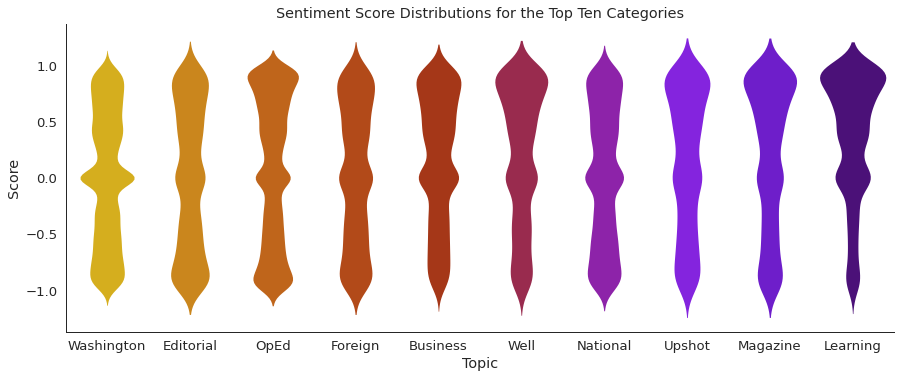

In [214]:
# graphing the top 10 categories

top10 = (comments.groupby('newDesk')['articleID'].count()
         .reset_index().sort_values('articleID',
                                    ascending=False)
         .head(10).newDesk)

top10_comments = comments[comments['newDesk'].isin(top10)]


# create plot

plot = sns.catplot(y="vaderScore", x="newDesk", 
            kind="violin", data=top10_comments,
            inner='quartile',
            split=True, linewidth=0, 
            aspect=2.5,)

plot.set(title="Sentiment Score Distributions for the Top Ten Categories",
         ylabel="Score", xlabel="Topic")

plot.savefig(file_path + "images/top10.png")

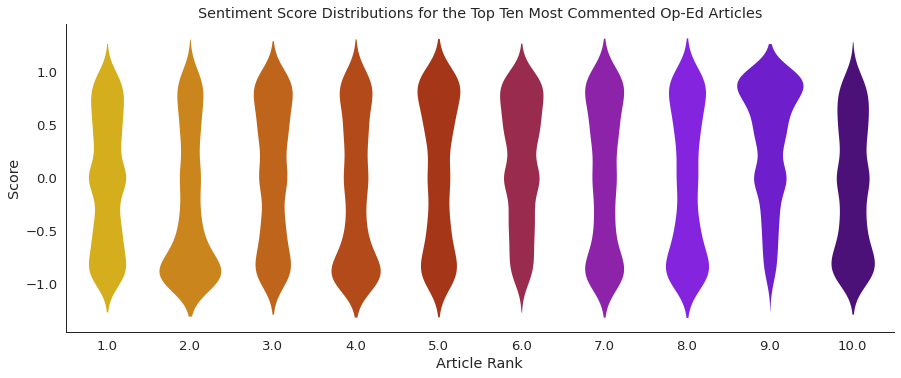

In [215]:
# sample topic top ten articles 

oped_ranked = (comments[comments['newDesk'] == 'OpEd']
              .groupby('articleID')['newDesk'].count().reset_index()
              .sort_values('newDesk', ascending=False))

oped_ranked['rank'] = oped_ranked['newDesk'].rank(ascending=False)
oped_top10 = oped_ranked[oped_ranked['rank'] <= 10 ].articleID

oped_top10_comments = comments[comments['articleID'].isin(oped_top10)]

oped_top10_comments = oped_top10_comments.merge(oped_ranked, 
                                                on='articleID', 
                                                how='left')

# create plot

plot = sns.catplot(y="vaderScore", x='rank', 
            kind="violin", data=oped_top10_comments,
            inner='quartile',
            split=True, linewidth=0, 
            aspect=2.5)

plot.set(title="Sentiment Score Distributions for the Top Ten" +
         " Most Commented Op-Ed Articles",
         ylabel="Score", xlabel="Article Rank")

plot.savefig(file_path + "images/oped_top10.png")

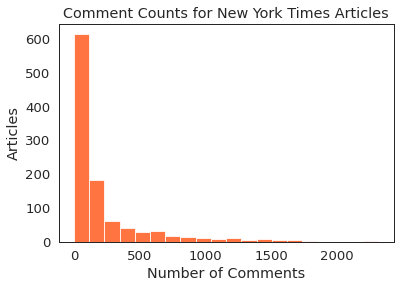

In [238]:
# graphing comment counts

plot = sns.histplot(x='commentCount', 
                    data=articles,
                    bins=20,
                    color='orangered')

plot.set(title="Comment Counts for New York Times Articles",
         ylabel="Articles", xlabel="Number of Comments")

plt.savefig(file_path + "images/commentCounts.png")